In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient
from cs231n.classifiers.convnet import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=19000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    x_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (19000L, 3L, 32L, 32L)
Train labels shape:  (19000L,)
Validation data shape:  (1000L, 3L, 32L, 32L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


#1. Sanity check loss

In [5]:
model = init_five_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = five_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = five_layer_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

Sanity check loss (no regularization):  2.30262289504
Sanity check loss (with regularization):  12.7936550112


#2. Grandient check

In [6]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_five_layer_convnet(input_shape=input_shape)
loss, grads = five_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: five_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 1.036756e-02
W2 max relative error: 3.157961e-02
W3 max relative error: 2.434976e-02
W4 max relative error: 2.192372e-02
W5 max relative error: 1.243110e-02
b1 max relative error: 6.567179e-04
b2 max relative error: 2.569620e-05
b3 max relative error: 2.396572e-06
b4 max relative error: 3.070989e-01
b5 max relative error: 1.876309e-08


# Train a net

In [14]:
model = init_five_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, five_layer_convnet,
          reg=0.001, update = 'rmsprop', learning_rate=3e-5, batch_size=40, num_epochs=2,
          verbose=True, acc_frequency=100,usesaved=True)

starting iteration  0
Finished epoch 0 / 2: cost 1.893707, train: 0.325000, val 0.333000, lr 3.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 2: cost 1.656708, train: 0.423000, val 0.418000, lr 3.000000e-05
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 2: cost 1.633575, train: 0.413000, val 0.431000, lr 3.000000e-05
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
Finished epoch 

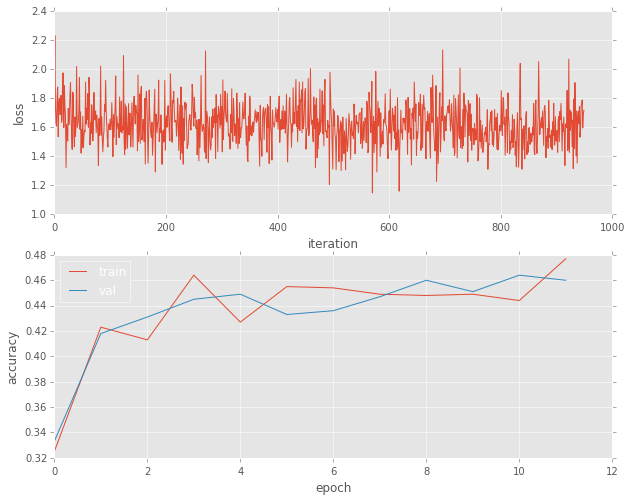

In [15]:
plt.style.use('ggplot')
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()